In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [3]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
    mdpKernelParams = pickle.load(f)
mdpPolicyStochastic = MdpKernel()
mdpPolicyStochastic.load_policy(mdpKernelParams, policyMode="stochastic")
mdpPolicyDeterministic = MdpKernel()
mdpPolicyDeterministic.load_policy(mdpKernelParams, policyMode="deterministic")

# ==== Prepare Simulator====
num_windows = 5000
obvMode = "predicted" # "perfect" or "predicted"

policySimulator = PolicySimulator(mdpPolicyDeterministic, env)
simResultDeterministic = policySimulator.runSimulation(mdpPolicyDeterministic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
'''
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultDeterministic['uRecord'], 
    simResultDeterministic['actionsRecord'], 
    simResultDeterministic['rewardRecord'], 
    simResultDeterministic['uNextRecord']
)
'''
policySimulator = PolicySimulator(mdpPolicyStochastic, env)
simResultStochastic = policySimulator.runSimulation(mdpPolicyStochastic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
uRecord = np.concatenate((simResultStochastic['uRecord'], simResultDeterministic['uRecord']))
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultStochastic['uRecord'] + simResultDeterministic['uRecord'], 
    simResultStochastic['actionsRecord'] + simResultDeterministic['actionsRecord'], 
    simResultStochastic['rewardRecord'] + simResultDeterministic['rewardRecord'], 
    simResultStochastic['uNextRecord'] + simResultDeterministic['uNextRecord']
)

Simulation Progress: 100%|██████████| 5000/5000 [00:11<00:00, 432.74it/s, avg reward=0.007960]


In [7]:
diffusionQParams = {
    'device': 'cuda',
    'gamma': 0.99,
    'tau': 0.005,
    'lr': 1e-2,
    'eta': 0.1,
    'N_action_candidates': 50
}
diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict, info = diffusionPolicyInterface.train(
    (uRecord, actionsRecord, rewardRecord, uNextRecord), 
    env,
    clonePolicy=True,
    epochs=500, 
    batch_size=512,
    updateCriticOnly=False)

Evaluation windows: 100%|██████████| 500/500 [00:09<00:00, 51.31it/s]                                       


Epoch   50/ 500  Avg Ld=0.073474  Avg Lq=-2.854641  Avg loss_critic=0.003362  Test packet loss=0.0052


Evaluation windows: 100%|██████████| 500/500 [00:08<00:00, 57.32it/s]                                        


Epoch  100/ 500  Avg Ld=0.039056  Avg Lq=-6.725464  Avg loss_critic=0.002248  Test packet loss=0.0059


Evaluation windows: 100%|██████████| 500/500 [00:06<00:00, 74.51it/s]                                         


Epoch  150/ 500  Avg Ld=0.038448  Avg Lq=-10.800648  Avg loss_critic=0.002357  Test packet loss=0.0059


Evaluation windows: 100%|██████████| 500/500 [00:07<00:00, 65.66it/s]                                         


Epoch  200/ 500  Avg Ld=0.039074  Avg Lq=-14.774382  Avg loss_critic=0.003450  Test packet loss=0.0082


Evaluation windows: 100%|██████████| 500/500 [00:06<00:00, 74.83it/s]                                         


Epoch  250/ 500  Avg Ld=0.035446  Avg Lq=-18.503884  Avg loss_critic=0.012322  Test packet loss=0.0059


Evaluation windows: 100%|██████████| 500/500 [00:10<00:00, 48.96it/s]                                         


Epoch  300/ 500  Avg Ld=0.034864  Avg Lq=-22.060095  Avg loss_critic=0.031346  Test packet loss=0.0054


Evaluation windows: 100%|██████████| 500/500 [00:07<00:00, 63.81it/s]                                         


Epoch  350/ 500  Avg Ld=0.034875  Avg Lq=-25.561844  Avg loss_critic=0.052416  Test packet loss=0.0048


Evaluation windows: 100%|██████████| 500/500 [00:07<00:00, 68.91it/s]                                         


Epoch  400/ 500  Avg Ld=0.033739  Avg Lq=-28.943911  Avg loss_critic=0.044753  Test packet loss=0.0062


Evaluation windows: 100%|██████████| 500/500 [00:06<00:00, 73.38it/s]                                         


Epoch  450/ 500  Avg Ld=0.033429  Avg Lq=-32.183384  Avg loss_critic=0.072149  Test packet loss=0.0082


Evaluation windows: 100%|██████████| 500/500 [00:06<00:00, 75.23it/s]                                         

Epoch  500/ 500  Avg Ld=0.032413  Avg Lq=-35.197147  Avg loss_critic=0.053107  Test packet loss=0.0052


In [8]:
# Save the trained model state dictionary
import torch
torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
print(f"Model saved to Results/DiffusionQ/diffusionQ_config{configIdx}.pth")
with open(f'Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(info, f)
print(f"Info saved to Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl")

Model saved to Results/DiffusionQ/diffusionQ_config0.pth
Info saved to Results/DiffusionQ/diffusionQ_info_config0.pkl


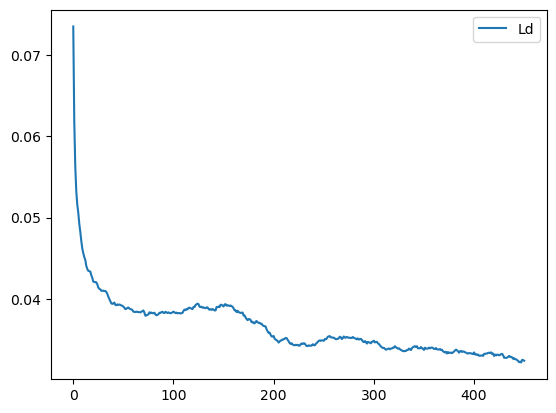

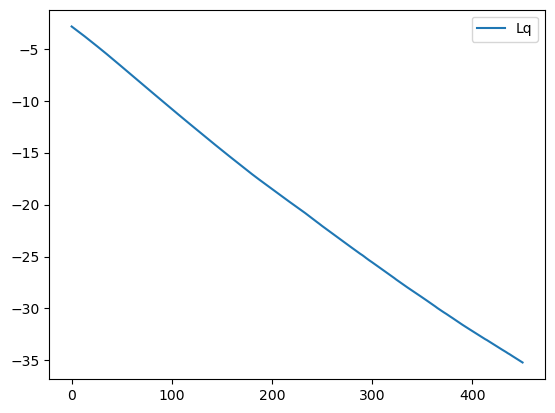

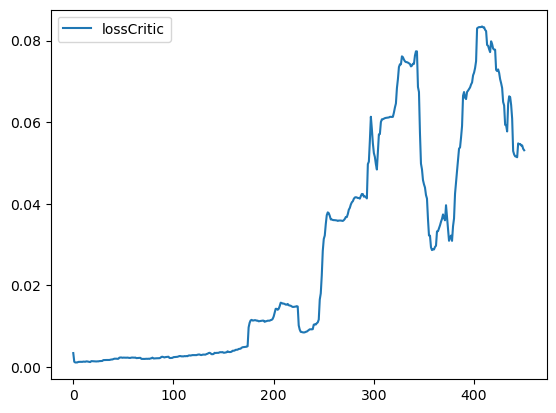

In [9]:
def smooth(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

obv_idxs = -1000
window_size = 50
plt.plot(smooth(info['LdRecord'][obv_idxs:], window_size=window_size), label="Ld")
plt.legend()
plt.show()
plt.plot(smooth(info['LqRecord'][obv_idxs:], window_size=window_size), label="Lq")
plt.legend()
plt.show()
plt.plot(smooth(info['lossCriticRecord'][obv_idxs:], window_size=window_size), label="lossCritic")
plt.legend()
plt.show()